In [1]:
# General path setup and library loading
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

from jdaviz import Imviz
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as uu
from astropy.table import Table
from astropy.io import fits

from loguru import logger

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

Load VASCA region

In [2]:
region_name = "TDS_ELAI"
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
display(rg.tt_fields)

field_id,name,ra,dec,observatory,obs_filter,fov_diam,sel,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id
,,deg,deg,,,deg,,,s,d,d,
bytes22,bytes22,float64,float64,bytes22,bytes22,float32,bool,int32,float32,float64,float64,int32
GNU2597312684324028416,PS_ELAISN1_MOS10,242.50638203682297,55.9801443588634,GALEX,NUV,1.2,True,24,29566.4,54960.17787037037,56821.33210648148,0
GNU2597383053068206080,PS_ELAISN1_MOS11,244.57200462478102,55.1825511621234,GALEX,NUV,1.2,True,25,31369.5,54960.24638888889,56815.50054271557,1
GNU2597453421812383744,PS_ELAISN1_MOS12,242.896209389035,55.0003489374844,GALEX,NUV,1.2,True,21,26349.451,54960.314884259256,56814.569061234084,2
GNU2597523790556561408,PS_ELAISN1_MOS13,241.28881797574297,55.3529870930308,GALEX,NUV,1.2,True,22,27810.902,54960.38337962963,56819.53759259259,3
GNU2597594159300739072,PS_ELAISN1_MOS14,243.95513153083402,54.1978605194106,GALEX,NUV,1.2,True,22,26881.852,54960.451886574076,56810.60611111111,4
GNU2597664528044916736,PS_ELAISN1_MOS15,242.396514585217,53.9999872930018,GALEX,NUV,1.2,True,22,28044.65,54960.52040509259,56810.67461805556,5
GNU2597734896789094400,PS_ELAISN1_MOS16,241.37385712300306,54.4519391954855,GALEX,NUV,1.2,True,21,26780.799,54960.588912037034,56807.7931854022,6


Get TDS & VASCA data and match them positionally

In [3]:
#Select vasca sources, 5 sigma 0.000000573303, 4 sigma 0.00006334, 3 sigma = 0.002699796
sel_vasca = (rg.tt_sources["flux_cpval"]<0.00006334) * (rg.tt_sources["flux_cpval"]>-0.5)

rg.tt_sources["sel"][:]=sel_vasca
tt_vasca = rg.tt_sources[sel_vasca]

#Read TDS
tt_tds_all = Table.read("./TDS-ApJ_766_60/table4.fit", hdu="J_ApJ_766_60_table4")
ids = tt_tds_all["ID"].data.astype(dtype=str)
sel_elai = (np.char.find(ids, 'ELAI') > -1)
tt_tds = tt_tds_all[sel_elai]
tt_tds['RAJ2000'].name = 'ra'
tt_tds['DEJ2000'].name = 'dec'

#Match VASCA-TDS
pos_tds = SkyCoord(ra=tt_tds["ra"], dec=tt_tds["dec"], unit="deg", frame="icrs")
pos_vasca = SkyCoord(ra=tt_vasca["ra"], dec=tt_vasca["dec"], unit="deg", frame="icrs")

match_dist = 10 * uu.arcsec
idx_tds, dist_tds, _ = pos_vasca.match_to_catalog_sky(pos_tds)
tt_vasca["tds_recno"]=tt_tds[idx_tds]["recno"]
tt_vasca["tds_idx"]=idx_tds
tt_vasca["tds_dist"]=dist_tds.to("arcsec")
tt_vasca["tds_match"] = tt_vasca["tds_dist"] < match_dist

idx_vasca, dist_vasca, _ = pos_tds.match_to_catalog_sky(pos_vasca)
tt_tds["rg_src_id"]=tt_vasca[idx_vasca]["rg_src_id"]
tt_tds["vasca_idx"]=idx_vasca
tt_tds["vasca_dist"]=dist_vasca.to("arcsec")
tt_tds["vasca_match"] = tt_tds["vasca_dist"] < match_dist

display(tt_vasca[:2])
display(tt_tds[:2])

fd_src_id,ra,dec,pos_err_mean,pos_err,pos_var,nr_det,nr_uls,mag_mean,mag_err_mean,mag_var,flux_cpval,flux_rchiq,mag_dmax,mag_dmax_abs,mag_dmax_sig,ul_weight,mag_sig_int2,mag_skew,sel,rg_fd_id,rg_src_id,nr_fd_srcs,tds_recno,tds_idx,tds_dist,tds_match
,deg,deg,deg,deg,deg,,,mag,mag,mag2,,,mag,mag,,,mag,,,,,,,,arcsec,
int32,float64,float64,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int32,int32,int32,int32,int64,float64,bool
-1,243.83818983251092,55.08296928201447,0.00014899448,2.4107425e-05,1.6393348e-07,38,0,18.152977,0.016116723,0.0014387821,1.14517825e-23,5.3177404,0.083631516,0.083631516,5.5382524,-1.0,0.0011790333,-0.6056382,True,-1,40,2,630,99,124.11912559952819,False
-1,243.77537884347873,55.124972484909236,0.00014886484,2.3398523e-05,1.3833213e-07,40,0,18.97335,0.023484373,0.0051505277,0.0,8.67562,0.18053818,0.18053818,7.483809,-1.0,0.004599012,-0.7184787,True,-1,83,2,630,99,75.92000649028184,False


recno,ID,ra,dec,l_mlow,mlow,l_Dmmax,Dmmax,l_sigint,sigint,l_Sd,Sd,l_Sy,Sy,LC,Mph,rmag,OT,z,X,Class,rg_src_id,vasca_idx,vasca_dist,vasca_match
,,deg,deg,,mag,,mag,,mag,,mag,,mag,,,mag,,,,,,,arcsec,
int32,bytes16,float64,float64,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,bytes3,float32,bytes3,float32,bytes1,bytes12,int32,int64,float64,bool
3,ELAISN1_MOS15-02,242.0397,54.3586,>,22.89,>,4.03,,1.37,,0.84,,2.93,V,pt,22.51,QSO,--,,CV,1103,15,0.5463,True
4,ELAISN1_MOS15-09,242.3685,53.6738,>,23.03,>,4.02,,1.23,,0.01,,2.15,F,ext,21.05,,--,,Galaxy Trans,42236,413,1.6676,True


In [7]:
sel_tmv = tt_tds["vasca_match"]
sel_vmt = tt_vasca["tds_match"]
print("Nr. matched sources VASCA/TDS:",sel_tmv.sum(),"/",sel_vmt.sum())
print("Nr. sources VASCA/TDS :",len(tt_vasca),"/",len(tt_tds))

ids_tds = tt_tds["ID"].data.astype(dtype=str)
sel_tds_mos15 = (np.char.find(ids_tds, 'MOS15') > -1)
tt_tds_mos15 = tt_tds[sel_tds_mos15]
print("Total Nr of TDS sources from MOS15:",len(tt_tds_mos15))
display(tt_tds_mos15[tt_tds_mos15["vasca_match"]==False]["recno","ID","ra","dec"])

Nr. matched sources VASCA/TDS: 102 / 100
Nr. sources VASCA/TDS : 610 / 160
Total Nr of TDS sources from MOS15: 26


recno,ID,ra,dec
,,deg,deg
int32,bytes16,float64,float64
71,ELAISN1_MOS15-20,242.8292,53.7492
184,ELAISN1_MOS15-24,243.0512,54.2599
307,ELAISN1_MOS15-03,242.1960,54.0721
390,ELAISN1_MOS15-22,242.8843,53.5921
417,ELAISN1_MOS15-18,242.7775,53.9643
441,ELAISN1_MOS15-13,242.4726,53.6579
495,ELAISN1_MOS15-00,241.6487,54.3255
873,ELAISN1_MOS15-14,242.6429,53.4919


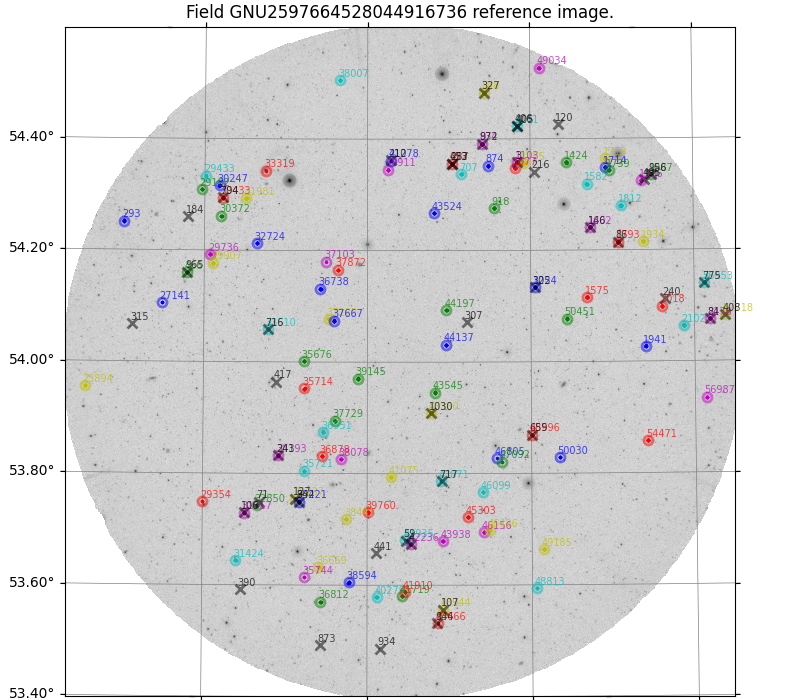

In [5]:
#PS_ELAISN1_MOS15 is field_id GNU2597664528044916736 (TDE PS1-10jh field)
field_id = rg.tt_fields["field_id"][5]
fd = rg.fields[field_id]
fig, ax = vvis.plot_field_sky_map(fd, img_idx=-1, sky_region = fd.get_sky_region()) # 
ax = vvis.plot_sky_sources(rg.tt_sources,tt_det=rg.tt_detections, sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs))

plot_tds = {"marker":"x","color":"k"}
ax = vvis.plot_sky_sources(tt_tds, src_id="recno",src_kwargs=plot_tds, sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs))

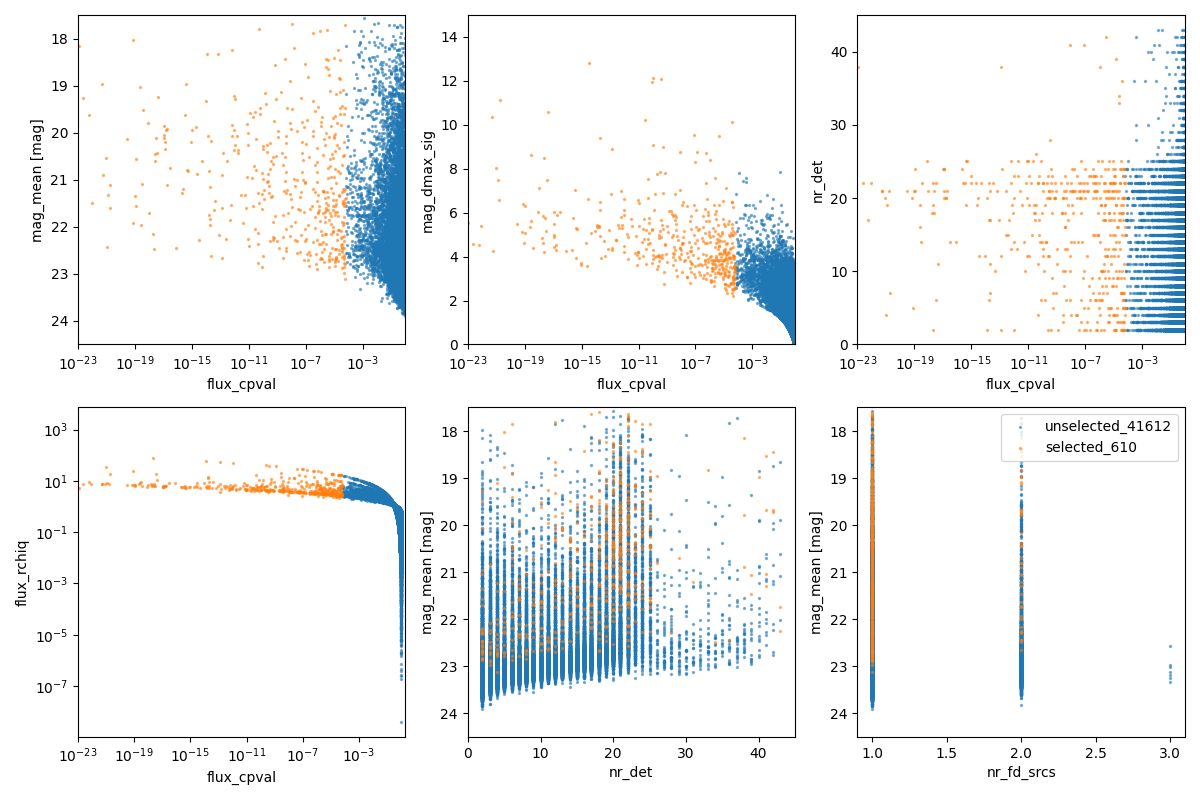

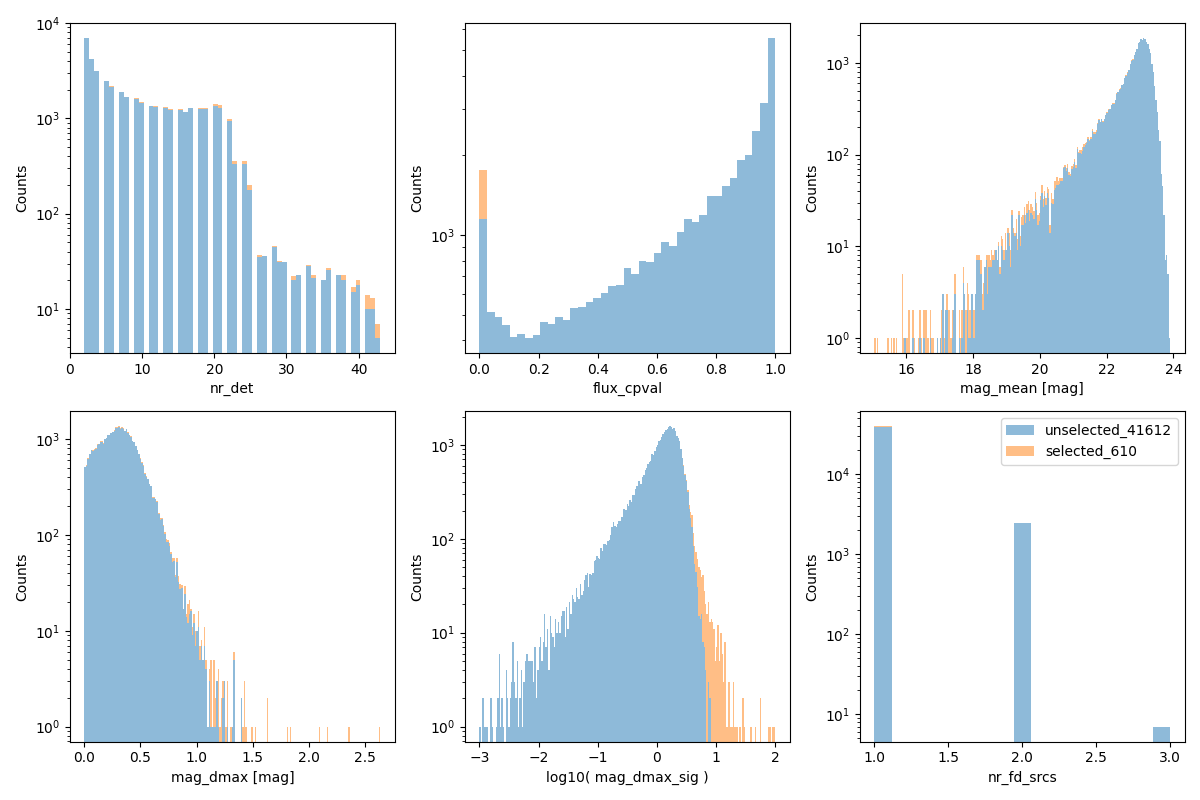

In [6]:
import vasca.visualization as vvis
fig_fd_det_diag_scat = vvis.plot_pipe_diagnostic(rg, "tt_sources", "scatter")
fig_rg_src_diag_hist, plot_pars = vvis.plot_pipe_diagnostic(rg, "tt_sources", "hist")
#fig_det_diag_hist, plot_pars = vvis.plot_pipe_diagnostic(fd, "tt_detections", "hist",fig_size=(8, 10))